In [1]:
from pathlib import Path

import rasterio
import numpy as np
from skimage.exposure import match_histograms

import matplotlib.pyplot as plt

In [2]:
# Load original (12-band) Sentinel-2 image
with rasterio.open("/home/data/ThinkingEarth/granollers/last_subset_S2B_MSIL2A_20250205_1000x1000_resampled.tif") as src_orig:
    orig_data = src_orig.read()  # shape: (12, H, W)
    orig_meta = src_orig.meta

# Load superresolved (3-band RGB) image
with rasterio.open("/home/data/ThinkingEarth/granollers/granollers_super_resolved.tiff") as src_super:
    super_data = src_super.read()  # shape: (3, H, W)
    super_meta = src_super.meta

In [ ]:
def hist_match_image_3d(img_target: "np.ndarray", img_ref: "np.ndarray") -> "np.ndarray":
    """
    Args:
        img_target (np.ndarray): The image to be calibrated. Shape (channels, height, width).
        img_ref (np.ndarray): The image to be used as a reference for the histogram matching. Shape must be the same as img_target.
    
    Returns:
        img_cal (np.ndarray): The calibrated image. The shape is the same as the img_target.
    """
    assert img_target.shape == img_ref.shape, "The shapes of input images must be exactly the same."
    img_cal = match_histograms
    

Be careful with the sequence of the bands. The Sentinel-2 bands are in reverse order (i.e., blue, green, red, nir etc.), while the output of the model is in the conventional order (i.e., red, green, blue). For long-term use, it would be wiser to have it in the Sentinel-2 reverse order, because the final downscaled GeoTIFF will have all the bands, so it makes more sense to keep the reversed order.

In [41]:
# Histogram match each band of superresolved image to the closest original band
# Assume Band 1 (Blue), 2 (Green), 3 (Red) correspond to bands 2, 3, 4 in Sentinel-2
matched_data = np.empty_like(super_data)
ref_bands = [1, 2, 3]  # match superresolved RGB to S2 B2 (Blue), B3 (Green), B4 (Red)
sr_bands = [2, 1, 0]
for sr_i, ref_i in zip(sr_bands, ref_bands):
    matched_data[sr_i] = match_histograms(super_data[sr_i], orig_data[ref_i], channel_axis=None)

# Save the matched image
matched_meta = super_meta.copy()
matched_meta.update(dtype=rasterio.float32)

with rasterio.open("/home/data/ThinkingEarth/granollers/granollers_super_resolved_matched_calibrated_bgr.tif", 'w', **matched_meta) as dst:
    matched_data = matched_data[::-1]
    dst.write(matched_data.astype(rasterio.float32))

print("Histogram matching complete. Output saved to matched_superresolved.tif")

Histogram matching complete. Output saved to matched_superresolved.tif


In [42]:
with rasterio.open("/home/data/ThinkingEarth/granollers/granollers_super_resolved.tiff") as src:
    temp = src.read()         # shape: (bands, height, width)
    profile = src.profile

    # Reverse the band order (e.g., from RGB to BGR)
    temp_reversed = temp[::-1]

    with rasterio.open("/home/data/ThinkingEarth/granollers/granollers_super_resolved_bgr.tiff", "w", **profile) as dst:
        dst.write(temp_reversed)

In [48]:
with rasterio.open("/home/data/ThinkingEarth/granollers/last_subset_S2B_MSIL2A_20250205_1000x1000_resampled.tif") as src:
    temp = src.read()         # shape: (bands, height, width)
    profile = src.profile
    profile.update({"count": 11})

    # Reverse the band order (e.g., from RGB to BGR)
    temp_clipped = temp[1:, ...]

    with rasterio.open("/home/data/ThinkingEarth/granollers/last_subset_S2B_MSIL2A_20250205_1000x1000_resampled_clipped.tif", "w", **profile) as dst:
        dst.write(temp_clipped)

In [43]:
def normalize(array, max_dn=5000):
    return np.clip(array / max_dn, 0, 1)

In [44]:
# Select RGB bands
blue = orig_data[1].astype(np.float32)
green = orig_data[2].astype(np.float32)
red = orig_data[3].astype(np.float32)

# Stack as RGB image for plotting
rgb = np.dstack((normalize(red), normalize(green), normalize(blue)))

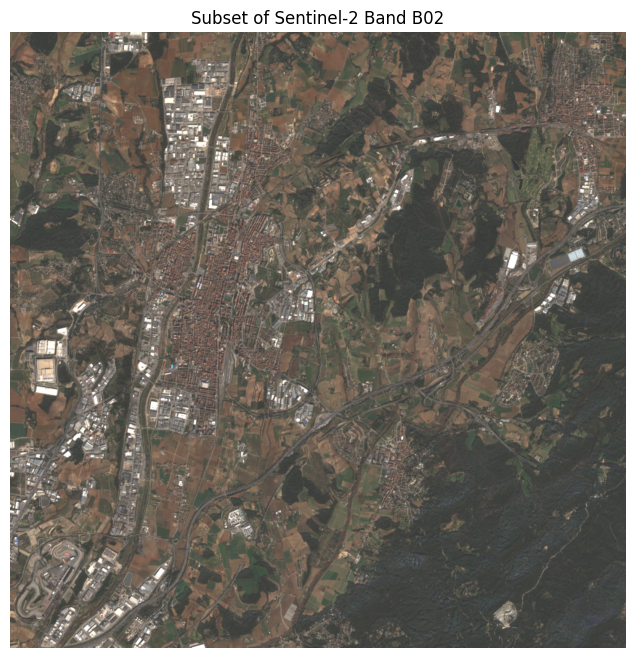

In [45]:
plt.figure(figsize=(8, 8))
plt.imshow(rgb)  # Use 'viridis' or other colormaps for variety
# plt.colorbar(label='Pixel Value')
plt.title("Subset of Sentinel-2 Band B02")
plt.axis('off')
plt.show()

In [35]:
# Select RGB bands
blue = matched_data[2].astype(np.float32)
green = matched_data[1].astype(np.float32)
red = matched_data[0].astype(np.float32)

# Stack as RGB image for plotting
rgb_matched = np.dstack((normalize(red), normalize(green), normalize(blue)))

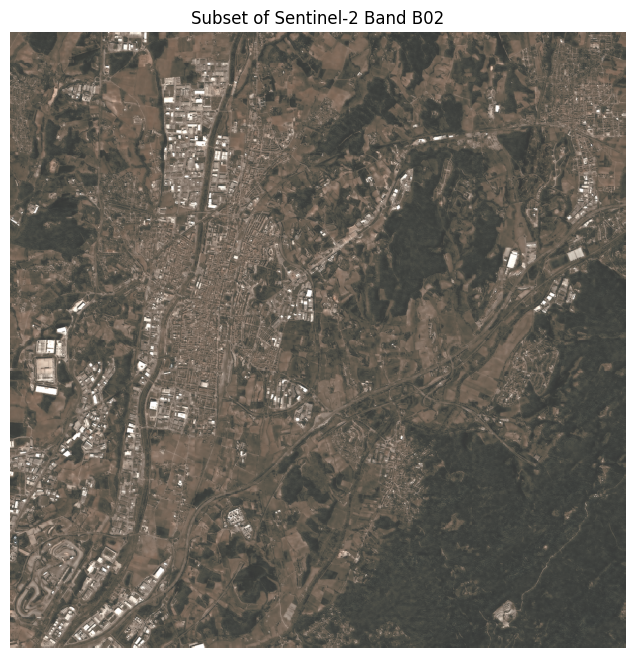

In [36]:
plt.figure(figsize=(8, 8))
plt.imshow(rgb_matched)  # Use 'viridis' or other colormaps for variety
# plt.colorbar(label='Pixel Value')
plt.title("Subset of Sentinel-2 Band B02")
plt.axis('off')
plt.show()

### Histogram Matching for single layer

In [73]:
def hist_match_img_2d(target_img: str = "", ref_img: str = "", write: bool = True) -> tuple:
    """
    Takes two geotiffs that have one band, performs intercalibration with histogram matching, and writes the calibrated 
    geotiff in the same folder as the target_img.
    
    Args:
        target_img (str): The path to the image to be calibrated.
        ref_img (str): The path to the image to be used as reference.
    
    Returns:
         tuple: A tuple containing:
            - np.ndarray: The calibrated image.
            - dict: Associated metadata of the geotiff.
    """
    # Load reference image
    with rasterio.open(ref_img) as src_ref:
        ref_data = src_ref.read()  # shape: (1, H, W)
        ref_meta = src_ref.meta

    # Load target image
    with rasterio.open(target_img) as src_target:
        target_data = src_target.read()  # shape: (1, H, W)
        target_meta = src_target.meta
    
    # Histogram match each band of superresolved image to the closest original band
    cal_data = np.empty_like(target_data)
    cal_data = match_histograms(target_data, ref_data, channel_axis=None)

    # Save the matched image
    cal_meta = target_meta.copy()
    cal_meta.update(dtype=rasterio.float32)
    
    if write==True:
        path = Path(target_img)
        with rasterio.open(path.parent/(path.stem + "_cal" + path.suffix), 'w', **cal_meta) as dst:
            dst.write(cal_data.astype(rasterio.float32))
    
    return cal_data, cal_meta

# Example
target_cal = hist_match_img_2d(target_img="/home/data/ThinkingEarth/granollers/calibrated_mgrvi.tif",
                               ref_img="/home/data/ThinkingEarth/granollers/original_mgrvi.tif")